# Portfolio: Ross Mularski

In [1]:
# imports
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
from IPython import display
from matplotlib.animation import FuncAnimation
from scipy import linalg
from scipy import optimize
from scipy import fft
from scipy import integrate
from scipy.io.wavfile import read as wavread

# Fundamental Physical Constants

NIST maintains a list of the values of all known physical constants. I downloaded that list as a .txt file and wrote a program to process its data to find the physical constant with the largest fractional uncertainty. My program printed the name of that constant and its fractional uncertainty.

In [3]:
with open("allascii.txt") as f:
    data = f.read()

# remove white space and title from txt file, put all data into one list
data1 = data.strip()
data2 = data1[376:]
data3 = data2.splitlines()
data4 = [i[:110] for i in data3]

# create separate lists of quantites, values, and uncertainties
quantities, values, uncertainties =  [i[:60] for i in data4], [i[60:85] for i in data4], [i[85:] for i in data4]

# create empty lists for values and uncertainties
# the current lists are lists of strings, we need to convert the lists of strings into lists of floats
values2 = []
uncertainties2 = []

# remove blank spaces and ellipses from list of values and turn into list of floats
values2 = [i.replace(" ", "") for i in values]
values3 = [i.replace("...", "") for i in values2]
values4 = list(map(float, values3))

# remove blank spaces etc. from list of uncertainties and turn into list of floats
uncertainties2 = [i.replace(" ", "") for i in uncertainties]
uncertainties3 = [i.replace("(exact)", "0.0") for i in uncertainties2]
uncertainties4 = list(map(float,uncertainties3))

# calculate the fractional uncertainty, find its max value and identify the quantitiy to which it belongs
# print result
frac_uncert = [i/j for i, j in zip(uncertainties4, values4)]
max_frac_uncert = max(frac_uncert)
indx = frac_uncert.index(max_frac_uncert) 
print("Quantity:", quantities[indx], "\n""Fractional Uncertainty: ", max_frac_uncert)

Quantity: proton rms charge radius                                     
Fractional Uncertainty:  0.002258141193249346


# Planetary orbits

The orbit of the planets around the Sun is elliptical. If given the distance  ℓ1  of the closest approach that a planet makes to the Sun, its perihelion, and its linear velocity  𝑣1  at perihelion, then any other property of the orbit can be calculated.

Kepler's second law tells us that the distance $\ell_2$ and velocity $v_2$ of the planet at its most distant point, or *aphelion*, satisfy $\ell_2 v_2 = \ell_1 v_1$. At the same time, the total energy&mdash;kinetic plus gravitational&mdash;of a planet with velocity $v$ and distance $r$ from the Sun is given by
$$E = \frac12 m v^2 - G \frac{mM}{r}\,,$$
where $m$ is the planet's mass, $M=1.9891\times10^{30}$ kg is the mass of the sun, and $G=6.6738\times10^{-11}$ m$^3$kg$^{-1}$s$^{-2}$ is Newton's gravitational constant. Given that energy must be conserved, $v_2$ is the smaller root of the quadratic equation
$$v_2^2 - \frac{2GM}{v_1\ell_1} v_2 - \left[ v_1^2 - \frac{2GM}{\ell_1}\right] = 0\,.$$
With $v_2$ we can calculate $\ell_2$ using the relation $\ell_2 = \ell_1 v_1/v_2$.

Given the values of $v_1$, $\ell_1$, and $\ell_2$, other parameters of the orbit are given by simple formulas can that be derived from Kepler's laws and the fact that the orbit is an ellipse:

>Semi-major axis: $a = \frac12(\ell_1+\ell_2)\,,$
>
>Semi-minor axis: $b = \sqrt{\ell_1\ell_2}\,,$
>
>Orbital period: $T = \displaystyle{\frac{2\pi ab}{\ell_1 v_1}}\,,$
>
>Orbital eccentricity: $e = \displaystyle{\frac{\ell_2-\ell_1}{\ell_2+\ell_1}}\,.$

For the eight planets in the solar system, the perihelion distance and perihelion velocity are given below. 

| Planet | Perihelion ($10^6$ km) | Max Velocity (km/s) |
|:-|:-:|:-:|
| Mercury | 46.00 | 58.98 |
| Venus | 107.48 | 35.26 |
| Earth | 147.09 | 30.29 |
| Mars | 206.62 | 26.50 |
| Jupiter | 740.52 | 13.72 |
| Saturn | 1352.55 | 10.18 |
| Uranus | 2741.30 | 7.11 |
| Neptune | 4444.45 | 5.50 |

With the above data, I was able to calculate and write the following to a file named `orbits.txt`.
1. The planet's name
2. $\ell_1$ (in AU, where 1 AU is the average Earth-Sun distance = $a_\mathrm{Earth}$)
3. $\ell_2$ (in AU)
4. $v_1$ (in km/s)
5. $v_2$ (in km/s)
6. $a$ (in AU)
7. $b$ (in AU)
8. $T$ (in years)
9. $e$

In [4]:
# constants
M = 1.9891e30 # kg
G = 6.6738e-11/1e9 # km/kg*s^2
AU = 149597870.7 # km in 1 AU
yr = 60*60*24*365 # seconds in a year

# lists
L1 = [46.00e6, 107.48e6, 147.09e6, 206.62e6, 740.52e6, 1352.55e6, 2741.30e6, 4444.45e6] # km
L1_inAU = [46.00e6/AU, 107.48e6/AU, 147.09e6/AU, 206.62e6/AU, 740.52e6/AU, 1352.55e6/AU, 2741.30e6/AU, 4444.45e6/AU]
L2 = [] # km
L2_inAU = []
v1 = [58.98, 35.26, 30.29, 26.50, 13.72, 10.18, 7.11, 5.50] # km/s
v2 = [] # km/s
a = [] # AU
b = [] # AU
T = [] # years
e = []

for i, j, k, l, m, n, o in zip(range(8), range(8), range(8), range(8), range(8), range(8), range(8)):
    
    v2_formula = .5*((2*G*M)/(v1[j]*L1[i])  - math.sqrt(((2*G*M)/(v1[j]*L1[i]))**2  + (4*v1[j]**2) - (8*G*M)/(L1[i])))  
    v2.append(v2_formula)
    L2_formula = L1_inAU[k]*v1[j]/v2[l]
    L2.append(L2_formula*AU)
    L2_inAU.append(L2_formula)
    a_formula = 0.5*(L1_inAU[k] + L2_inAU[m])
    a.append(a_formula)
    b_formula = (L1_inAU[k]*L2_inAU[m])**(1/2)
    b.append(b_formula)
    T_formula = 2*math.pi*a[n]*b[o]*AU/(L1_inAU[k]*v1[j]*yr)
    T.append(T_formula)
    e_formula = (L2_inAU[m] - L1_inAU[k])/(L1_inAU[k] + L2_inAU[m])
    e.append(e_formula)

# Create and open.txt file, write header
with open("orbits.txt", "w") as file:
    
    header = "Planet      L1(AU)      L2(AU)      v1(km/s)      v2(km/s)      a(AU)      b(AU)      T(years)      e"
    mer = f"Mercury     {L1_inAU[0]:.2f}        {L2_inAU[0]:.2f}        {v1[0]:.2f}         {v2[0]:.2f}         {a[0]:.2f}       {b[0]:.2f}       {T[0]:.2f}          {e[0]:.2f}"
    ven = f"Venus       {L1_inAU[1]:.2f}        {L2_inAU[1]:.2f}        {v1[1]:.2f}         {v2[1]:.2f}         {a[1]:.2f}       {b[1]:.2f}       {T[1]:.2f}          {e[1]:.2f}"
    ear = f"Earth       {L1_inAU[2]:.2f}        {L2_inAU[2]:.2f}        {v1[2]:.2f}         {v2[2]:.2f}         {a[2]:.2f}       {b[2]:.2f}       {T[2]:.2f}          {e[2]:.2f}"
    mar = f"Mars        {L1_inAU[3]:.2f}        {L2_inAU[3]:.2f}        {v1[3]:.2f}         {v2[3]:.2f}         {a[3]:.2f}       {b[3]:.2f}       {T[3]:.2f}          {e[3]:.2f}"
    jup = f"Jupiter     {L1_inAU[4]:.2f}        {L2_inAU[4]:.2f}        {v1[4]:.2f}         {v2[4]:.2f}         {a[4]:.2f}       {b[4]:.2f}       {T[4]:.2f}         {e[4]:.2f}"
    sat = f"Saturn      {L1_inAU[5]:.2f}        {L2_inAU[5]:.2f}       {v1[5]:.2f}         {v2[5]:.2f}          {a[5]:.2f}       {b[5]:.2f}       {T[5]:.2f}         {e[5]:.2f}"
    ura = f"Uranus      {L1_inAU[6]:.2f}       {L2_inAU[6]:.2f}       {v1[6]:.2f}          {v2[6]:.2f}          {a[6]:.2f}      {b[6]:.2f}      {T[6]:.2f}         {e[6]:.2f}"
    nep = f"Neptune     {L1_inAU[7]:.2f}       {L2_inAU[7]:.2f}       {v1[7]:.2f}          {v2[7]:.2f}          {a[7]:.2f}      {b[7]:.2f}      {T[7]:.2f}        {e[7]:.2f}"
    file.write(header + "\n")
    file.write(mer + "\n")
    file.write(ven + "\n")
    file.write(ear + "\n")
    file.write(mar + "\n")
    file.write(jup + "\n")
    file.write(sat + "\n")
    file.write(ura + "\n")
    file.write(nep + "\n")

# Kepler's Third Law

I downloaded a file called `exoplanets.csv`, which contains orbital and physical parameters for 2950 exoplanets.

From the file, I extracted the data from the following three columns:
1. MSTAR (the mass of the planet's star)
2. A (the semi-major axis of the planet's orbit)
3. PER (the period of the planet's orbit)

I used this data to verify Kepler's 3rd Law, which says that
$$T^2\propto\frac{a^3}{M}\,,$$
where $T$ is the period of the orbit, $a$ is the semimajor axis, and $M$ is the mass of the *star*. My plot shows that the proportionality constant is equal to 1 if the units of period are in years, the semi-major axis is in AU (astronomical units), and the mass of the star is in units of solar masses.

I created a scatter plot of $a^3/M$ versus $T^2$ for values of $T$ less than 20 years and plotted a straight line of slope 1. As you can see, the points all lie on the line $y = x$. This verifies that the proportionality constant is indeed 1.

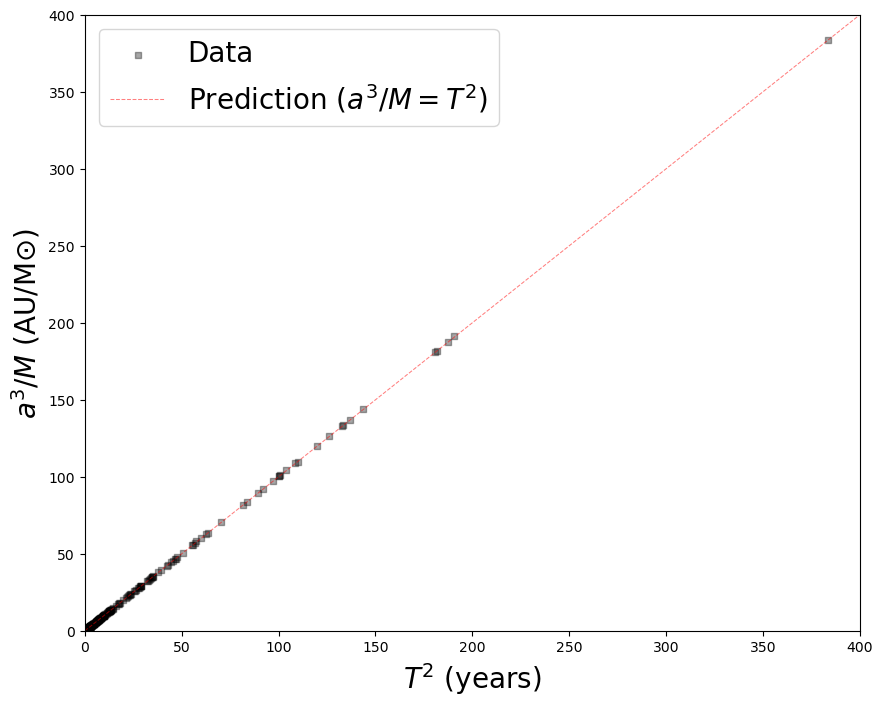

In [5]:
# get rid of warning message
np.seterr(invalid = "ignore")

# identify file
file = "exoplanets.csv" 

# pull only relavant data, put into arrays
M, a, days = np.genfromtxt(file, delimiter = ",", usecols = (1, 2, 3), unpack = True)

# convert period from days to years
T = days/365.25 

# assign x, y for scatter plot
x = T**2 
y = (a**3)/M

# for line y = x, the prediction
i = np.linspace(0, 400, 400)

# Create plot
plt.figure(figsize = (10, 8))
ax = plt.axes()
ax.scatter(x, y, s = 20, c = "k", marker = ",", alpha = 0.35, label = "Data")
ax.plot(i, i, c = "r", linestyle = "dashed", alpha = 0.5, linewidth = 0.75, label = "Prediction ($a^3/M = T^2$)")
plt.xlim(0, 400) # 20^2 = 400
plt.ylim(0, 400)
plt.xlabel("$T^2$ (years)", fontsize = 20)
plt.ylabel("$a^3/M$ (AU/M$\odot$)", fontsize = 20)
plt.legend(loc = 2, prop = {"size":20})
plt.show()

# Waves in 2-D

The equation
$$z(x,y) = z_0\sin\left(k\sqrt{x^2+y^2}-\omega t\right)$$
describes a circular set of waves centered on the origin that propagate outwards as time progresses.

I created an animated `imshow` of the wave, using $z_0=1$, $k=1$, and $\omega=1$, to keep things simple.

The animation loops smoothy and the code is optimized to run as quickly as possible because the length of the animation is exactly one period.

In [6]:
# create arrays of x and y values
x = np.linspace(-10*np.pi, 10*np.pi, 150)
y = np.linspace(-10*np.pi,10*np.pi, 150)
x, y = np.meshgrid(x, y)
z = [[]]

# create figure and plot
fig = plt.figure()
im = plt.imshow(z, cmap = "seismic", vmin = -1, vmax = 1, origin = "upper", extent = (-10*np.pi, 10*np.pi, -10*np.pi, 10*np.pi))
plt.colorbar()

# animation function
def animate(frame): 
    
    z = np.sin((x**2 + y**2)**(1/2) - frame/20*np.pi)
    im.set_data(z)
    
anim = FuncAnimation(fig, animate, frames = 40, interval = 20)
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

# Brownian Motion

Brownian motion is the motion of a particle, such as a smoke or dust particle, as it is buffeted by random collisions with gas molecules. I made a simple computer simulation of such a particle in two dimensions.

My program performs 200 steps of a random walk on a lattice with $L=25$. I have animated the position of the particle at each step.

In [7]:
# set up figure
fig = plt.figure()
dots = plt.plot([], "o")
dot = dots[0]

# set x, y limits
plt.xlim(-12.5, 12.5)
plt.ylim(-12.5, 12.5)
plt.title("Brownian Motion")

# arrays to store coordinates
x = np.zeros(200) 
y = np.zeros(200)

# random walk function
def random_walk(i):
    
    for n in range(i):
        
        step = random.randint(1, 4)
        
        if step == 1 and y[n - 1] != 12: # step up
            x[n] = x[n - 1]
            y[n] = y[n - 1] + 1
            
            if y[n - 1] == 12: # if at boundary, step down
                x[n] = x[n - 1]
                y[n] = y[n - 1] - 1
        
        elif step == 2 and y[n - 1] != -12: # step down
            x[n] = x[n - 1]
            y[n] = y[n - 1] - 1 
            
            if y[n - 1] == -12: # if at boundary, step up
                x[n] = x[n - 1]
                y[n] = y[n - 1] + 1
        
        elif step == 3 and x[n - 1] != -12: # step left
            x[n] = x[n - 1] - 1
            y[n] = y[n - 1]
            
            if x[n - 1] == -12: # if at boundary, step right
                x[n] = x[n - 1] + 1
                y[n] = y[n - 1]
        
        else: # step right
            x[n] = x[n - 1] + 1
            y[n] = y[n - 1]
            
            if x[n - 1] == 12:
                x[n] = x[n - 1] - 1 # ff at boundary, step left
                y[n] = y[n - 1]  
    
    return x,y # returns arrays with coordinates of random walk

random_walk(200)

# animate random walk 
def animation(frame):
    
    x1 = x[frame]
    y1 = y[frame]
    dot.set_data((x1,y1))

anim = FuncAnimation(fig, animation, frames = 200, interval = 50)
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

# Calculating Shadows

When light strikes a surface, the amount falling per unit area depends not only on the intensity of the light, but also on the angle of incidence. The resulting intensity of illumination is $a\cos\theta$, where $a$ is the raw
intensity of the light. This simple physical law allows us to calculate how light falls on three-dimensional objects and hence how they will look when illuminated from various angles.

Suppose, for instance, that we are looking down on the silicon from above. We know the height of the surface $w(x,y)$ as a function of position in the plane, so the equation for the surface is simply $z=w(x,y)$, or equivalently $z-w(x,y)=0$, and the normal
vector $\vec{v}$ to the surface is given by the gradient of $z-w(x,y)$ thus:

$$\vec{v} = \vec{\nabla} [z-w(x,y)] = \begin{pmatrix}\partial/\partial x \\ \partial/\partial y \\ \partial/\partial z \end{pmatrix} [z-w(x,y)] = \begin{pmatrix}-\partial w/\partial x \\ -\partial w/\partial y \\ 1 \end{pmatrix}\,.$$

Now suppose we have light coming in represented by a vector $\vec{a}$ with magnitude equal to the intensity of the light. Then the dot product of the vectors $\vec{a}$ and $\vec{v}$ is

$$\vec{a}\cdot\vec{v} = |\vec{a}|\,|\vec{v}|\cos\theta\,,$$

where $\theta$ is the angle between the vectors. Thus the intensity of illumination of the surface is

$$I = |\vec{a}| \cos\theta = \frac{\vec{a}\cdot\vec{v}}{|\vec{v}|} = \frac{-a_x (\partial w/\partial x) - a_y (\partial w/\partial y) + a_z}{\sqrt{(\partial w/\partial x)^2 + (\partial w/\partial y)^2 + 1}}\,.$$

In turn, the illumination can be expressed in terms of a pair of angles that describe the location of the sun in the sky:

$$\vec{a}=(\cos\theta\cos\phi,\,\cos\theta\sin\phi,\,\sin\theta)\,,$$

where $\theta$ represents the altitude angle, and $\phi$ represents the azimuthal angle (measured counterclockwise from the $+x$-axis). For simplicity I've to set the magnitude $|\vec{a}|=1$.

I downloaded a file containing an Scanning Tunneling Microscope (STM) image of the surface of silicon, stored as a 2-D array. I plotted the data with `imshow` and enhanced the image by calculating how it would look illuminated by a fixed light source.

I used `gradient` to calculate the derivatives $\partial w/\partial x$ and $\partial w/\partial y$ at each grid point.

Using the values for the derivatives, I calculated the intensity for each grid point, with $\theta=20^\circ$ and $\phi=30^\circ$. I made a density plot of the resulting values in which the brightness at each point depends on the corresponding intensity value.

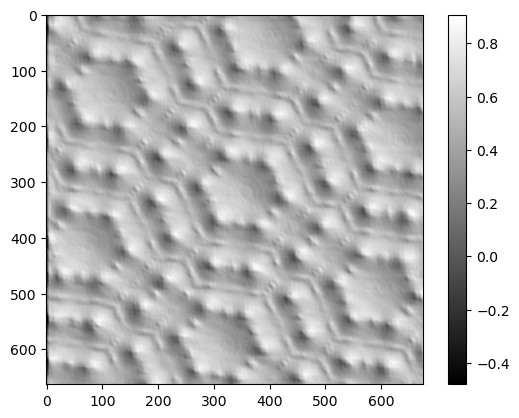

In [8]:
# identify file
file = "stm.txt"
A = np.loadtxt(file) 

# find gradient
grady, gradx = np.gradient(A, 2.5)

alt_angle = (np.pi/180)*20 # theta
azi_angle = (np.pi/180)*30 # phi

# formulas for ax, ay, az
ax = np.cos(alt_angle)*np.cos(azi_angle) 
ay = np.cos(alt_angle)*np.sin(azi_angle)
az = np.sin(azi_angle)

fig = plt.figure()
I = (-ax*gradx - (-1*ay)*grady + az) / (gradx**2 + grady**2 + 1)**(1/2) # -1*ay to properly orient shadows
plt.imshow(I, cmap = "gray")
plt.colorbar()
plt.show()

# Eigenfrequencies

I created an animation that shows a system of four identical masses and five ideal springs vibrating horizontally at each of its four *eigenfrequencies*.

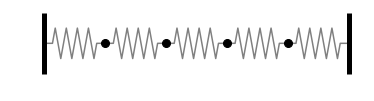

Let $x_0$, $x_1$, $x_2$, and $x_3$ be the horizontal displacement of each mass from equilibrium, numbered from left to right. (In the figure above, $x_0 = x_1 = x_2 = x_3 = 0$.) The four equations of motion of the masses are given by

$$\begin{align*}
-2kx_0 + kx_1 &= m\ddot{x}_0\,, \\
kx_0 - 2kx_1 + kx_2 &= m\ddot{x}_1\,, \\
kx_1 - 2kx_2 + kx_3 &= m\ddot{x}_2\,, \\
kx_2 - 2kx_3 &= m\ddot{x}_3\,.
\end{align*}$$

To find the eigenfrequencies $\omega$ of the system, I exploited the fact that the solution to a simple harmonic oscillator takes the form $\ddot{x}_i = -\omega^2 x_i$, and put the equations above into the form

$$\mathbf{Mx}=\frac{\omega^2}{\omega_0^2}\mathbf{x}\,,$$

where $\mathbf{M}$ is a matrix with the coefficients from the equation of motion and $\omega_0=\sqrt{k/m}$ is the natural frequency of each spring. To simplify things I chose units where $\omega_0 = 1$. We're left with an eigenvalue problem

$$\mathbf{Mx}=\omega^2\mathbf{x}\,$$

where $\omega$ are the angular *eigenfrequencies*.

In [9]:
# draw the spring system with matplotlib
def draw_spring(left, right):
    
    dy = 0.5
    x = np.linspace(left, right, 23)
    y = np.array([0]*4 + [dy, 0, -dy, 0]*4 + [0]*3)
    spring = plt.Line2D(x, y, linestyle = "-", color = "gray", zorder = -1)
    ax = plt.gca()
    ax.add_line(spring)

def draw_chain(x_offsets):
    
    x = np.arange(2, 10, 2) + x_offsets
    
    # draw springs
    draw_spring(0, x[0],)
    draw_spring(x[0], x[1])
    draw_spring(x[1], x[2])
    draw_spring(x[2], x[3])
    draw_spring(x[3], 10)
    
    # draw masses
    plt.plot(x, [0, 0, 0, 0], "ko", ms = 8)
    
    # draw vertical bars at edges
    plt.vlines([0, 10], -1, 1, "k", lw = 5)

# coefficient matrix
M = np.array([[2,  -1,  0,  0],
              [-1,  2, -1,  0],
              [0,  -1,  2, -1],
              [0,   0, -1,  2]])

eigenvalues, eigenvectors = linalg.eigh(M) # w^2

# eigenfrequencies
w = (eigenvalues)**(1/2)

# create figure to animate
fig = plt.figure()

def animate(frame):
    
    fig.clear()
    
    ev1 = eigenvectors[:, 0] # eigenvectors corresponding to each spring
    ev2 = eigenvectors[:, 1]
    ev3 = eigenvectors[:, 2]
    ev4 = eigenvectors[:, 3]
    
    ef1 = np.cos(w[0]*frame/4) # eigenfrequencies corresponding to each spring
    ef2 = np.cos(w[1]*frame/4)
    ef3 = np.cos(w[2]*frame/4)
    ef4 = np.cos(w[3]*frame/4)
    
    plt.subplot(2, 2, 1)
    draw_chain([ev1[0]*ef1, ev1[1]*ef1, ev1[2]*ef1, ev1[3]*ef1])
    plt.axis("scaled")
    plt.axis("off")
    
    plt.subplot(2, 2, 2)
    draw_chain([ev2[0]*ef2, ev2[1]*ef2, ev2[2]*ef2, ev2[3]*ef2])
    plt.axis("scaled")
    plt.axis("off")
    
    plt.subplot(2, 2, 3)
    draw_chain([ev3[0]*ef3, ev3[1]*ef3, ev3[2]*ef3, ev3[3]*ef3])
    plt.axis("scaled")
    plt.axis("off")

    plt.subplot(2, 2, 4)
    draw_chain([ev4[0]*ef4, ev4[1]*ef4, ev4[2]*ef4, ev4[3]*ef4])
    plt.axis("scaled")
    plt.axis("off")

anim = FuncAnimation(fig, animate, frames = 165, interval = 20)
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

# Lagrange Points

The Lagrange points are the five points located around a pair of celestial bodies where the net gravitational field is exactly zero as measured in a co-rotating reference frame. I calculated and plotted the five Lagrange points for the Earth-Moon system.

In a reference frame that rotates about the earth-moon system's center of mass, the effective gravitational potential is

$$V=-\frac{GM}{r_E} - \frac{Gm}{r_m} - \tfrac12 r^2 \omega^2\,$$

where $G=6.674\times10^{-11}$ m$^3$kg$^{-1}$s$^{-2}$, $M=5.974\times10^{24}$ kg is the mass of the earth, $m=7.348\times10^{22}$ kg is the mass of the moon, and $\omega=2.662\times10^{-6}$ s$^{-1}$ is the orbital angular frequency of the moon about the earth-moon system's center of mass. The three distances $r_E$, $r_m$, and $r$ are measured from the earth, moon, and center of mass, respectively. Similar to some other problems we've seen

$$r = \sqrt{x^2 + y^2}\,,$$

$$r_E = \sqrt{(x-x_E)^2 + (y-y_E)^2}\,,$$

and

$$r_m = \sqrt{(x-x_m)^2 + (y-y_m)^2}\,,$$

where $(x_E, y_E)$ and $(x_m, y_m)$ are the locations of the earth and moon. To calculate the location of the earth and moon, I used the fact that the radius of the moon's orbit is $R=3.844\times10^8$ m.

Finally, the gravitation field is given by
    
$$\vec{F}=-\vec{\nabla}V\,.$$
    
The five locations where $|\vec{F}|=0$, are the Langrange Points. In principle, an object placed there could remain stationary relative to the earth and moon.

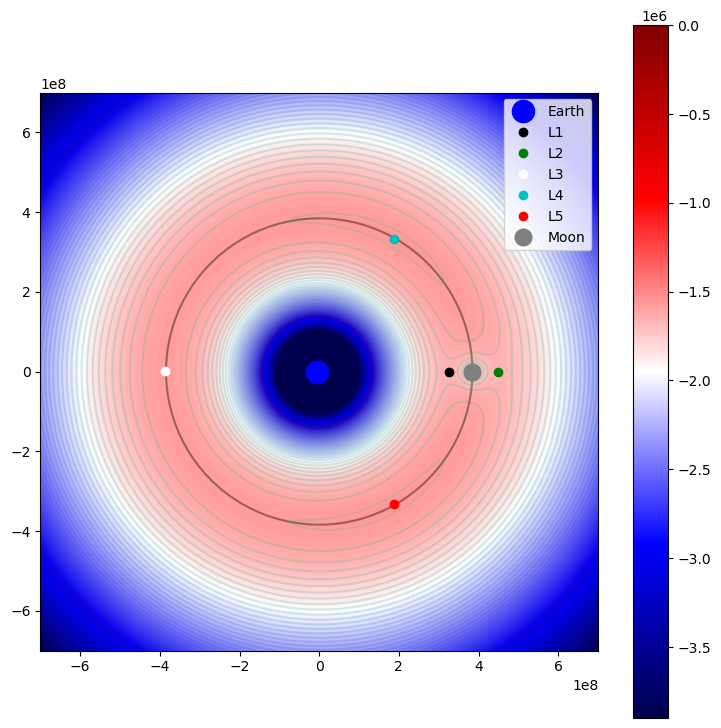

In [10]:
# constants
G = 6.674e-11 # gravitational constant
M = 5.974e24 # mass of earth, in kg
m = 7.348e22 # mass of moon, in kg
x_moon = 3.844e8 # moon's distance from center of mass, in meters
x_earth = -4.67e6 # earth's distance from center of mass, in meters
w = 2.662e-6 # angular frequency of moon

# create plot
plt.figure(figsize = (9, 9))
size = 7e8
plt.xlim(-size, size)
plt.ylim(-size, size)

# plot earth and moon on x-axis
plt.plot(x_earth, 0, "bo", markersize = 16, label = "Earth")

# plot moon's orbit
t = np.linspace(0, 2*np.pi, 100)
plt.plot(x_moon*np.cos(t), x_moon*np.sin(t), "-", color = "k", alpha = 0.4)

# contour plot of gravitational potential
x = np.linspace(-size, size, 500)
y = np.linspace(-size, size, 500)
x, y = np.meshgrid(x, y)

r = (x**2 + y**2)**(1/2) # distance from center of mass
re = ( (x - x_earth)**2 + y**2 )**(1/2) # distance from earth
rm = ( (x - x_moon)**2 + y**2 )**(1/2) # distance from moon

V = - G*M/re - G*m/rm - ( (r**2)*(w**2)/2 ) # gravitational potential formula

levels = np.linspace(-3e6, -1e6, 50)
plt.contour(V, alpha = .2, extent = (-size, size, -size, size), levels = levels)
plt.imshow(V, cmap = "seismic", origin = "lower", extent = (-size, size, -size, size), vmin = -3900000, vmax = 0)
plt.colorbar()

# functions to calculate gradient
def dfdx(x, y):
    return abs( ( ( G*M*(x - x_earth) ) / (x**2 - 2*x_earth*x + x_earth**2 + y**2)**(3/2) ) + ( ( G*m*(x - x_moon) ) / (x**2 - 2*x_moon*x + x_moon**2 + y**2)**(3/2) ) - x*w**2)

def dfdy(x, y):
    return abs( (G*M*y) / (x**2 - 2*x_earth*x + x_earth**2 + y**2)**(3/2) + (G*m*y) / (x**2 - 2*x_moon*x + x_moon**2 + y**2)**(3/2) - y*w**2)

def gfield(xy):
    x, y = xy
    return (dfdx(x, y)**2 + dfdy(x, y)**2)**(1/2)

# use the function and scipy.optimize to locate lagrange pts
# five estimates based on where contours on graph are furthest apart
guess_L1 = [3e8, 0]
guess_L2 = [4.5e8, 0] 
guess_L3 = [-4e8, 0]
guess_L4 = [2e8, 3e8]
guess_L5 = [2e8, -3e8]

result1 = optimize.minimize(gfield, guess_L1, method = "Nelder-Mead")
result2 = optimize.minimize(gfield, guess_L2, method = "Nelder-Mead")
result3 = optimize.minimize(gfield, guess_L3, method = "Nelder-Mead")
result4 = optimize.minimize(gfield, guess_L4, method = "Nelder-Mead")
result5 = optimize.minimize(gfield, guess_L5, method = "Nelder-Mead")

# add lagrange pts to plot
L1x, L1y = result1.x
L2x, L2y = result2.x
L3x, L3y = result3.x
L4x, L4y = result4.x
L5x, L5y = result5.x

plt.plot(L1x, L1y, "ko", label = "L1")
plt.plot(L2x, L2y, "go", label = "L2")
plt.plot(L3x, L3y, "wo", label = "L3")
plt.plot(L4x, L4y, "co", label = "L4")
plt.plot(L5x, L5y, "ro", label = "L5")
plt.plot(x_moon, 0, "o", color = "gray", markersize = 12, label = "Moon")
plt.legend()
plt.show()

# Fourier Transform of Sound

I downloaded a file named `trumpet.txt` containing the waveform of a trumpet playing the note C$_5$ (with a frequency of 523.251 Hz).

I calculated the Fourier transform of the trumpet's waveform, and plotted the power spectrum of the Fourier coefficients ($|c_k|^2$) for frequencies between zero and 4000 Hz. There are peaks at multiples 523.251 Hz, these are the harmonics.

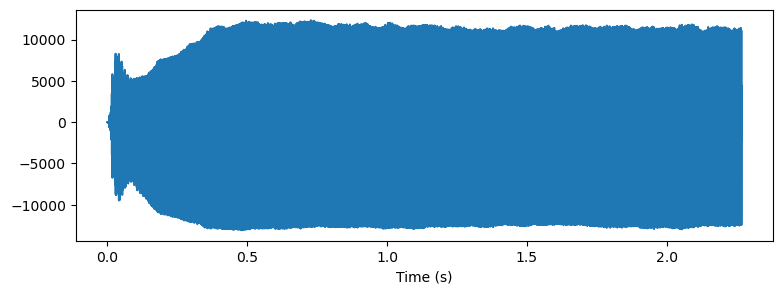

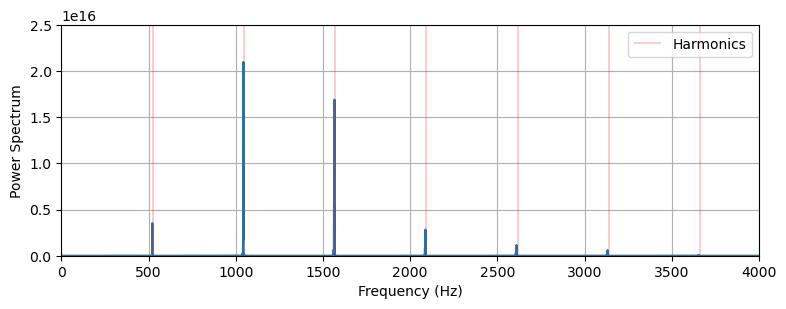

In [11]:
# identify file
file = "trumpet.txt"
trumpet = np.loadtxt(file)

# plot trumpet's waveform
t = np.linspace(0, len(trumpet)/44100, len(trumpet))
plt.figure(figsize = (9, 3))
plt.plot(t, trumpet)
plt.xlabel("Time (s)")
plt.show()

# calculate the power spectrum
c = fft.fft(trumpet)
power_spectrum = abs(c**2)

# find Nyquist frequency
N = len(power_spectrum)
dt = 1/44100
df = 1/(N*dt)
fNy = 1/(2*dt)

# plot trumpet's power spectrum
freq = np.arange(0, 2*fNy, df)
plt.figure(figsize = (9, 3))
plt.grid()
plt.plot(freq, power_spectrum) 
plt.xlim(0, 4000)
plt.ylim(0, 2.5e16)
harmonics = np.arange(0, 4000, 523.251)
plt.vlines(harmonics, 0, 2.5e16, colors = "r", alpha = 0.2, label = "Harmonics")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectrum")
plt.legend()
plt.show()

display.Audio(trumpet, rate = 44100)

I downloaded the file `StarWars.wav`, that contains the first few seconds of the *Star Wars* theme and analyzed the first chord. I plotted the chord's power spectrum and identified all the notes that make up that chord.

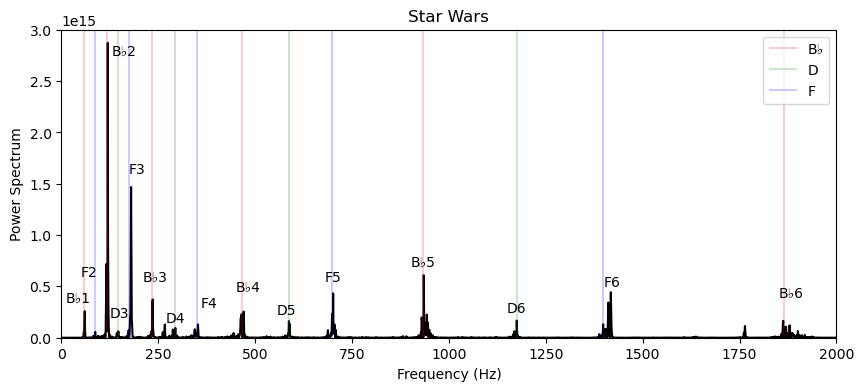

In [12]:
# identify file
rate, data = wavread("StarWars.wav")

# isolate first chord
chord1 = data[18950:68000]

# calculate power spectrum
c1 = fft.fft(chord1)
power_spectrum_c1 = abs(c1**2)

# find Nyquist frequency
N_c1 = len(chord1)
dt_c1 = 1/rate
df_c1 = rate/N_c1
fNy_c1 = 1/(2*dt_c1)

# plot power spectrum
freq_c1 = np.arange(0, 2*fNy_c1, df_c1)
plt.figure(figsize = (10,4))
plt.plot(freq_c1, power_spectrum_c1, "k") 
plt.xlim(0, 2000)
plt.ylim(0, 3e15)

# plot harmonics
k = np.argmax(power_spectrum_c1)*df_c1
harmonics_c1 = np.arange(0, 2000, k/2)
Bflat = np.array([58.27047, 116.5409, 233.0819, 466.1638, 932.3275, 1864.655])
D = np.array([146.8324, 293.6648, 587.3295, 1174.659])
F = np.array([87.30706, 174.6141, 349.2282, 698.4565, 1396.913])

plt.vlines(Bflat, 0, 3e15, colors = "r", alpha = 0.2, label = "B♭")
plt.vlines(D, 0, 3e15, colors = "g", alpha = 0.2, label = "D")
plt.vlines(F, 0, 3e15, colors = "b", alpha = 0.2, label = "F")
plt.title("Star Wars")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectrum")
plt.annotate("B♭1", (10, 0.35e15))
plt.annotate("B♭2", (130, 2.75e15))
plt.annotate("B♭3", (210, 0.55e15))
plt.annotate("B♭4", (450, 0.45e15))
plt.annotate("B♭5", (900, 0.70e15))
plt.annotate("B♭6", (1850, 0.40e15))
plt.annotate("F2", (50, 0.60e15))
plt.annotate("F3", (174, 1.60e15))
plt.annotate("F4", (360, .30e15))
plt.annotate("F5", (680, 0.55e15))
plt.annotate("F6", (1400, 0.50e15))
plt.annotate("D3", (125, 0.20e15))
plt.annotate("D4", (270, 0.15e15))
plt.annotate("D5", (555, 0.23e15))
plt.annotate("D6", (1150, 0.25e15))
plt.legend()
plt.show()

display.Audio(chord1, rate = rate)

# Double Pendulum

A double pendulum consists of a normal pendulum with another pendulum hanging from its end.

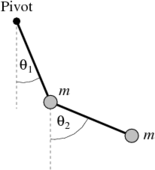

The position of the arms at any moment in time is uniquely specified by the two angles $\theta_1$ and $\theta_2$.  The equations of motion for the angles are most easily derived using the Lagrangian formalism. The resulting pair of equations are

$$\begin{align}
2\ddot\theta_1 + \ddot\theta_2 \cos(\theta_1-\theta_2) &+ \dot\theta_2^2 \sin(\theta_1-\theta_2) + 2{g\over\ell} \sin\theta_1 = 0\,,\\
\ddot\theta_2 + \ddot\theta_1 \cos(\theta_1-\theta_2) &- \dot\theta_1^2 \sin(\theta_1-\theta_2) + {g\over\ell} \sin\theta_2 = 0\,.
\end{align}$$

These second-order equations can be converted them into first-order ones by the usual method, defining two new variables, $\omega_1$ and $\omega_2$, thus:

$$\dot\theta_1 = \omega_1,\qquad \dot\theta_2 = \omega_2\,.$$

In terms of these variables the equations of motion become

$$\begin{align}
2\dot\omega_1 + \dot\omega_2 \cos(\theta_1-\theta_2) &+ \omega_2^2 \sin(\theta_1-\theta_2) + 2{g\over\ell} \sin\theta_1 = 0\,,\\
\dot\omega_2 + \dot\omega_1 \cos(\theta_1-\theta_2) &- \omega_1^2 \sin(\theta_1-\theta_2) + {g\over\ell} \sin\theta_2 = 0\,.
\end{align}$$

Finally we have to rearrange these into the standard form with a single derivative on the left-hand side of each one, which gives

$$\begin{align*}
\dot\omega_1 &= - {\omega_1^2\sin(2\theta_1-2\theta_2) + 2\omega_2^2\sin(\theta_1-\theta_2) + (g/\ell) \bigl[ \sin(\theta_1-2\theta_2) + 3 \sin\theta_1 \bigr]\over 3 - \cos(2\theta_1-2\theta_2)}, \\ \\
\dot\omega_2 &= {4\omega_1^2\sin(\theta_1-\theta_2) + \omega_2^2\sin(2\theta_1-2\theta_2) + 2(g/\ell) \bigl[ \sin(2\theta_1-\theta_2) - \sin\theta_2 \bigr]\over 3 - \cos(2\theta_1-2\theta_2)}.
\end{align*}$$

These two equations, along with the equations $\dot{\theta}_1=\omega_1$ and $\dot{\theta}_2=\omega_2$, give us four first-order equations which between them define the motion of the double pendulum.

I wrote a program that solved the equations of motion from $t=0$ to $t=60$ seconds for the case where $\ell=0.4$ meters, with the initial conditions $\theta_1=\theta_2=\pi$ rad, $\omega_1=0$, and $\omega_2=0.001$ rad/s.

I calculated the total energy of the system assuming that the mass $m=1$ kg, and made a graph of energy as a function of time from $t=0$ to $t=60$ seconds. For simplicity I ignored friction and assumed that both pendulums have bobs of the same mass $m$ and massless arms of the same length $\ell$.

I also animated the motion of the double pendulum in real time.

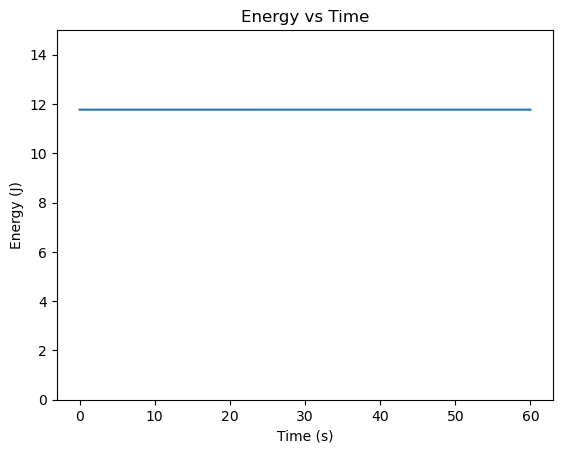

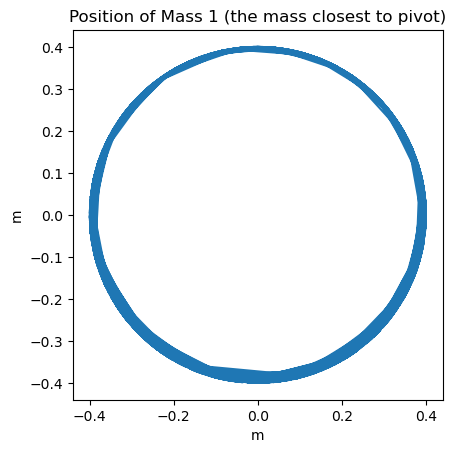

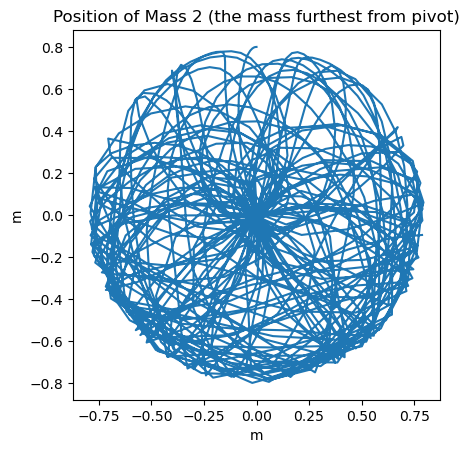

In [13]:
# constants
l = 0.40 # m
m = 1 # kg
g = 9.81 # m/s^2
th_0 = np.pi # rad
w1_0 = 0
w2_0 = 0.001 # rad/s

# set up ode
def f(t, r):
    
    th1, w1, th2, w2 = r
    A = (w1**2)*(np.sin(2*th1 - 2*th2))
    B = (2*w2**2)*(np.sin(th1 - th2))
    C = (g/l)*(np.sin(th1 -2*th2) + 3*np.sin(th1))
    D = (4*w1**2)*(np.sin(th1 - th2))
    E = (w2**2)*(np.sin(2*th1 - 2*th2))
    F = (2*g/l)*(np.sin(2*th1 - th2) - np.sin(th2))
    denominator = (3 - np.cos(2*th1 - 2*th2))
    dth1 = w1
    dw1 = -1*((A + B + C)/(denominator))
    dth2 = w2
    dw2 = (D + E + F)/(denominator)
    return dth1, dw1, dth2, dw2

# time from zero to sixty seconds
t = np.linspace(0, 60, 1200) 

# solved ode
sol = integrate.solve_ivp(f, (0, 60), (th_0, w1_0, th_0, w2_0), method = "RK23", t_eval = t, rtol = 1e-12)
theta1, omega1, theta2, omega2 = sol.y

T = l**2*(omega1**2 + 0.5*omega2**2 + omega1*omega2*np.cos(theta1 - theta2))
V = -g*l*(2*np.cos(theta1) + np.cos(theta2))
E = T + V

# Convert to cartesian coordinates
x1 = l*np.sin(theta1)
y1 = -l*np.cos(theta1)
x2 = l*np.sin(theta2) + x1
y2 = -l*np.cos(theta2) + y1

# plot of energy vs time, energy is conserved
plt.plot(t, E)
plt.title("Energy vs Time")
plt.ylim(0, 15)
plt.xlabel("Time (s)")
plt.ylabel("Energy (J)")
plt.show()

# plot of mass closest to pivot
plt.plot(x1, y1)
plt.axis("scaled")
plt.title("Position of Mass 1 (the mass closest to pivot)")
plt.xlabel("m")
plt.ylabel("m")
plt.show()

# plot of mass furthest from pivot
plt.plot(x2, y2)
plt.axis("scaled")
plt.title("Position of Mass 2 (the mass furthest from pivot)")
plt.xlabel("m")
plt.ylabel("m")
plt.show()

# create animation
def animate(i):     
    ln1.set_data([0, x1[i], x2[i]], [0, y1[i], y2[i]])      

fig, ax = plt.subplots(1,1, figsize=(8,8))  
ln1, = plt.plot([], [], 'ko-', lw = 3, markersize = 8) 
ax.set_xlim(-1, 1) 
ax.set_ylim(-1, 1) 
anim = FuncAnimation(fig, animate, frames = 1200, interval = 50) 
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()